In [1]:
%matplotlib inline
import numpy as np
from collections import Counter
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch import FloatTensor as FT
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.datasets import make_moons, make_blobs, make_swiss_roll
from skimage import filters
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Color Palette
#matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
#cm = ListedColormap(['#C82506', '#0365C0'])
cm = ListedColormap(sns.color_palette("Set2", 2).as_hex())
sns.set(context = 'paper', style='whitegrid', font_scale=1,
            rc={'font.family':'sans-serif', #'figure.figsize':(2.75,2)
            'font.size':'7','font.sans-serif':['cm'],"lines.linewidth":'0.3','legend.fontsize':'7'})
figures_path = Path('results/figures')
sns.color_palette("Set2", 2)#.as_hex()[1]
cms = 1/2.54 

## Metrics

In [3]:
from scipy.stats import ttest_rel, wilcoxon

def whitebox(output_1, output_2, label, labels):
    # clean output, unique feature output, canary label, all labels
    # Explanation of the metric: 
    # if samples with same class of the canary sample had the unique feature, 
    # a neural network which memorised said feature will have increased confidance (uncalibrated ?) in its prediction.
    # The increased confidance comes from unique feature, not from the real factors.

    # only evaluate on images with the same label as the ground truth canary
    indxs = (labels == label).nonzero()[0]

    output_2_f = output_2[indxs, label]
    output_1_f = output_1[indxs, label]

    m = (output_2_f - output_1_f).mean()

    r = ttest_rel(output_2_f, output_1_f, alternative='greater')
    pval = r.pvalue

    r = wilcoxon(output_2_f, output_1_f, alternative='greater')
    pval2 = r.pvalue

    return m, pval, pval2

# Intro

Theoretical Questions:

1. What's the / is there a difference between memorisation and learning?
2. How different the unique features needs to be?
3. Is it overfitting?
4. What is the effect of increasing dimensionality?

Other ideas

1. Train two models (one with unique feature and one without) - train 1000 models and get the average difference in decision boundary - self influence. Check the output of each layer. Is learning a more complex combination of features activations whereas memorisation is more specific?
2. 3d decision boundary
3. Instead of difference with the clean data points, experiment with a distribution around the unique features in the z axis. 
5. visualisation of NN weights
    1. By varying the number of spurious features, we might be able to visualise how the NN learn/memorise in different settings

# Data

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


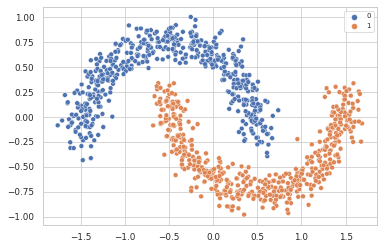

In [4]:
# create centered data
blob_std = 0.1
X, y = make_moons(n_samples=1000,  shuffle = True, noise = blob_std)
X -= np.mean(X,0)
X_extra_dim = np.concatenate([X, np.zeros((X.shape[0],1))], axis =1)
centers = np.array([np.max(X[y == 0], 0),
                    np.min(X[y == 1], 0)])
sns.scatterplot(X[:,0], X[:,1], y, cmap = cm);

In [5]:
# An n by n grid for the heatmap
n = 100
bb_min = -2
bb_max = 2
d1_min =  bb_min
d1_max =  bb_max
d2_min =  bb_min
d2_max =  bb_max
d1, d2 = torch.meshgrid([
    torch.linspace(d1_min, d1_max, n),
    torch.linspace(d2_min, d2_max, n)])
heatmap_plane = torch.stack((d1.flatten(), d2.flatten()), dim=1)

# Net

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3, 32)
        self.fc2 = nn.Linear(32, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 2)
            
    def forward(self, x, return_all = False):
        x1 = self.fc1(x)
        x2 = self.fc2(F.relu(x1))
        x3 = self.fc3(F.relu(x2))
        x4 = self.fc4(F.relu(x3))
        
        if return_all:
            return x1,x2,x3,x4
        else:
            return x4

# In distribution

## Training

In [7]:
def get_trained_net(X_th, y_th, epochs: int = 50):
    net = Net().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    loss_function = nn.CrossEntropyLoss(reduction='mean')
    pbar = range(epochs)#tqdm()
    for epoch in pbar:
        y_hat = net(X_th)
        loss = loss_function(y_hat,y_th)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(y_hat.data, 1)
        accuracy = (predicted == y_th).sum().item() / y_th.size(0)
        #pbar.set_postfix({"loss":loss.item(),"accuracy":accuracy})
    return net, accuracy

In [8]:
X_th, y_th = torch.FloatTensor(X_extra_dim).to(device), torch.LongTensor(y).to(device)
net, _ = get_trained_net(X_th, y_th, epochs = 40)

## Results

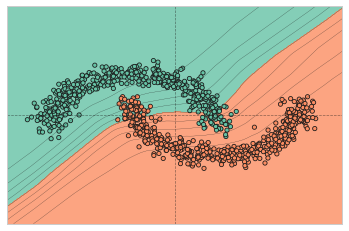

In [9]:
net.eval()
heatmap_plane_clean = torch.cat([heatmap_plane, torch.zeros(heatmap_plane.shape[0],1)], axis = 1)
heatmap_avg_clean = F.softmax(net(heatmap_plane_clean.to(device))).data.cpu().numpy()

# Plotting
figure = plt.figure()
hmp_x = heatmap_plane[:, 0].data.numpy().reshape(n, n)
hmp_y = heatmap_plane[:, 1].data.numpy().reshape(n, n)
hma = heatmap_avg_clean[:, 1].reshape(n, n)
ax = plt.subplot(1,1,1)
ax.contourf(hmp_x, hmp_y, hma, 1, cmap=cm, alpha=.8)
ax.contour(hmp_x, hmp_y, hma, 10, antialiased=True, linewidths=0.2, colors='k')
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm, edgecolors='k', s=18)
ax.axhline(y=0, ls='--', lw=0.7, color='k', alpha=0.5)
ax.axvline(x=0, ls='--', lw=0.7, color='k', alpha=0.5)
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

# Unique Extra Dim

## Data

In [16]:
X_extra_dim = np.concatenate([X, np.zeros((X.shape[0],1))], axis =1)
gauss_rand = np.random.randn(X.shape[0],1) * 0.0
X_extra_dim = np.concatenate([X, gauss_rand], axis =1)
print(gauss_rand.max())

y_outlier = 1
X_2dim_outlier = X[np.argwhere(y==y_outlier)[len(y)//4,0]]
#X_2dim_outlier = centers[1 - y_outlier]
X_outlier = np.concatenate([X_2dim_outlier,[1.0]], axis = 0)

X_plus_outlier = np.concatenate([X_extra_dim,[X_outlier]], 0)
y_plus_outlier = np.concatenate([y,[y_outlier]], 0)

X_extra_dim_clean = X_extra_dim#np.concatenate([X, np.zeros((X.shape[0],1))], axis =1)
X_extra_dim_unique = np.concatenate([X, np.ones((X.shape[0],1))], axis =1)

-0.0


findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.


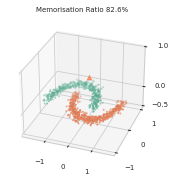

In [11]:
import matplotlib.style as mplstyle
import matplotlib
mplstyle.use('fast')
matplotlib.rcParams['path.simplify'] = True
matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['font.family'] = 'sans'
matplotlib.rcParams['legend.fontsize'] = 7
fig = plt.figure(figsize=(7*cms, 7*cms))
cm = ListedColormap(sns.color_palette("Set2", 2).as_hex())
ax = plt.axes(projection='3d')
ax.tick_params(axis='both', which='major', labelsize=7)
ax.scatter3D(X_plus_outlier[:-1,0], X_plus_outlier[:-1,1], X_plus_outlier[:-1,2], c=y_plus_outlier[:-1], s = 3,
            marker = 'o', 
            cmap = cm,
            edgecolor='k',
            linewidth=0.05,
            linestyle='-',);
ax.scatter3D(X_plus_outlier[-1,0], X_plus_outlier[-1,1], X_plus_outlier[-1,2], c=sns.color_palette("Set2", 2).as_hex()[1], s = 30,
            marker = '^', 
            edgecolor='k',
            linewidth=0.05,
            linestyle='-',);
ax.set_zlim3d([-0.5,1])
ax.set_zticks([-0.5,0,1])
ax.set_xticks([-2,-1,0,1,2])
ax.set_yticks([-2,-1,0,1,2])
ax.set_title(f'Memorisation Ratio {82.6}%', fontsize=7) # 0.826, 0.414
ax.view_init(30,-70);#ax.view_init(55,-70)
#plt.savefig(figures_path / f"data_with_outlier_flat.pdf", bbox_inches = 'tight')

## Results

### Did it memorise?

In [68]:
results_memorisation_all_runs = []

n_runs = 100
n_epochs = 100
for i in range(n_runs):
    results_memorisation = {'nets':[], 'pvalue':[], 'm':[], 'acc':[]}
    #net, acc = get_trained_net(X_th, y_th, epochs = n_epochs)
    net = Net().to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    loss_function = nn.CrossEntropyLoss(reduction='mean')
    for epoch in range(n_epochs):
        X_th, y_th = torch.FloatTensor(X_plus_outlier).to(device), torch.LongTensor(y_plus_outlier).to(device)
        y_hat = net(X_th)
        loss = loss_function(y_hat, y_th)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(y_hat.data, 1)
        acc = (predicted == y_th).sum().item() / y_th.size(0)

        X_th  = torch.FloatTensor(X_extra_dim_clean).to(device)
        clean_output = net(X_th).detach().cpu().numpy()

        X_unique_th = torch.FloatTensor(X_extra_dim_unique).to(device)
        unique_feature_output = net(X_unique_th).detach().cpu().numpy()

        m, pval, pval2 = whitebox(clean_output, unique_feature_output, y_outlier, y)
        results_memorisation['nets'].append(net)
        results_memorisation['pvalue'].append(pval)
        results_memorisation['m'].append(m)
        results_memorisation['acc'].append(acc)
        
    results_memorisation_all_runs.append(results_memorisation)

#memorised_net = results_memorisation['nets'][np.argmin(results_memorisation['pvalue'])]
#non_memorised_net = results_memorisation['nets'][np.argmax(results_memorisation['pvalue'])]

#memorised_net.eval()
#non_memorised_net.eval()

In [69]:
pvalues = []
accs = []
for run in results_memorisation_all_runs:
    pvalues.append(run['pvalue'])
    accs.append(run['acc'])
pvalues = np.array(pvalues)
accs = np.array(accs)
memorised_per_epoch = (pvalues < 0.025).sum(axis=0) / pvalues.shape[0]

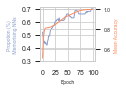

In [76]:
sns.set_style('whitegrid')
mplstyle.use('fast')
matplotlib.rcParams['path.simplify'] = True
fig = plt.figure(figsize=(2.5*cms, 2.5*cms))
ax = fig.add_subplot(111, aspect = 'auto')
ax.tick_params(labelsize=5)
ax.tick_params(axis='both', which='major', labelsize=7)
ax.plot(memorised_per_epoch, color = sns.color_palette("Set2", 3).as_hex()[2], linewidth = 1)
#ax.set_title(f'Proportion of Memorising NNs per Epoch', fontsize =7)
ax.set_ylabel("Propotion (%) \n Memorising NNs ", fontsize =5, color= sns.color_palette("Set2", 3).as_hex()[2])
ax.set_xlabel("Epoch", fontsize =5)
plt.yticks([0.3,0.4,0.5,0.6,0.7]);
plt.xticks([0,25,50,75,100]);
ax2=ax.twinx()
ax2.tick_params(labelsize=5)
ax2.plot(accs.mean(0), color = sns.color_palette("Set2", 3).as_hex()[1], linewidth = 1)
ax2.set_ylabel("Mean Accuracy ", fontsize =5, color= sns.color_palette("Set2", 3).as_hex()[1])

plt.savefig(figures_path / f"proportion_memorising_per_epoch.pdf", bbox_inches = 'tight')

(array([ 7.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  2., 82.]),
 array([0.96192057, 0.96572851, 0.96953646, 0.9733444 , 0.97715234,
        0.98096028, 0.98476823, 0.98857617, 0.99238411, 0.99619206,
        1.        ]),
 <BarContainer object of 10 artists>)

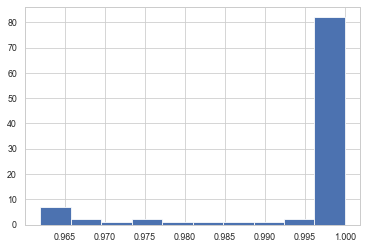

In [28]:
plt.hist(results_memorisation_all_runs[3]['pvalue'])

In [13]:
net_memorised = np.array(results_memorisation['pvalue']) < 0.1
print(f"Avegared M total {np.array(results_memorisation['m']).mean()}")
print(f"Avegared M memorised {np.array(results_memorisation['m'])[net_memorised].mean()}")
print(f"Proportion memorised {Counter(net_memorised)[True] / len(results_memorisation['m'])}")


Avegared M total 0.2528229355812073
Avegared M memorised 0.7185291051864624
Proportion memorised 0.7


Text(0.5, 0, "Student's test p-value")

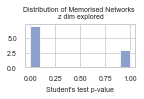

In [14]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(5*cms, 2*cms))
ax = fig.add_subplot(111, aspect = 'auto')
ax.tick_params(axis='both', which='major', labelsize=7)
ax.hist(results_memorisation['pvalue'], bins=10, color = sns.color_palette("Set2", 3).as_hex()[2]);
ax.set_title(f'Distribution of Memorised Networks \n z dim explored', # \n Runs {n_runs}, Epochs {n_epochs}, Mean Train Acc {np.mean(results_memorisation["acc"]):.2f}
         fontsize =7)
ax.set_xlabel("Student's test p-value", fontsize =7)
#ax.set_xlim([-2,2])
#plt.savefig(figures_path / f"distribution_memorised_epoch{n_epochs}_guass.pdf", bbox_inches = 'tight')

### Impact of added noise variance

In [21]:
X_extra_dim = np.concatenate([X, np.zeros((X.shape[0],1))], axis =1)

n_runs = 500
n_epochs = 100
noise_variances = [0,0.1,0.25,0.5]
ratio_memorised = []
for noise_var in noise_variances:
    
    gauss_rand = np.random.randn(X.shape[0],1) * noise_var
    X_extra_dim = np.concatenate([X, gauss_rand], axis =1)

    #create canary sample
    y_outlier = 1
    X_2dim_outlier = X[np.argwhere(y==y_outlier)[len(y)//4,0]]
    X_outlier = np.concatenate([X_2dim_outlier,[1.0]], axis = 0)
    
    #add canary sample to dataset
    X_plus_outlier = np.concatenate([X_extra_dim,[X_outlier]], 0)
    y_plus_outlier = np.concatenate([y,[y_outlier]], 0)

    X_extra_dim_clean = X_extra_dim#np.concatenate([X, np.zeros((X.shape[0],1))], axis =1)
    X_extra_dim_unique = np.concatenate([X, np.ones((X.shape[0],1))], axis =1)

    pvalues = [] 
    for i in range(n_runs):
        X_th, y_th = torch.FloatTensor(X_plus_outlier).to(device), torch.LongTensor(y_plus_outlier).to(device)
        net, acc = get_trained_net(X_th, y_th, epochs = n_epochs)

        X_th  = torch.FloatTensor(X_extra_dim_clean).to(device)
        clean_output = net(X_th).detach().cpu().numpy()

        X_unique_th = torch.FloatTensor(X_extra_dim_unique).to(device)
        unique_feature_output = net(X_unique_th).detach().cpu().numpy()

        m, pval, pval2 = whitebox(clean_output, unique_feature_output, y_outlier, y)
        pvalues.append(pval)
    memorised = np.count_nonzero(np.array(pvalues) < 0.1)
    ratio_memorised.append(memorised/n_runs)

In [22]:
print(ratio_memorised)

[0.826, 0.414, 0.746, 0.644]


### Get feature map distribution

In [17]:
# Plot the mean difference between the weights of models trained with and without the outlier.
# White box metric 2 to only look at the weights for networks that memorised

def get_latent_feature_map(net, X_data):
    layers = net(torch.FloatTensor(X_data).to(device), return_all = True)
    sizes = [layer.shape[1] for layer in layers]
    layers_resampled = [layer.detach().cpu().numpy().repeat(max(sizes)//layer.shape[1], axis=1) for layer in layers]#max(sizes)
    layers_resampled = np.stack(layers_resampled,axis=-1)
    return layers_resampled

indxs = (y == y_outlier).nonzero()[0]

latent_feature_map_clean = get_latent_feature_map(memorised_net, X_extra_dim_clean[indxs])
latent_feature_map_unique = get_latent_feature_map(memorised_net, X_extra_dim_unique[indxs])

latent_feature_map_clean_non = get_latent_feature_map(non_memorised_net, X_extra_dim_clean[indxs])
latent_feature_map_unique_non = get_latent_feature_map(non_memorised_net, X_extra_dim_unique[indxs])

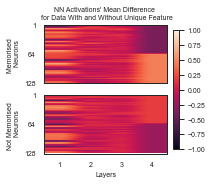

In [18]:
sns.set_style('white')
'''
When it doesnt memorise, the unique feature increases on AVERAGE the confidence but not INDIVIDUALLY.
When it does memorise, the confidence with and without unique features are high on AVERAGE but the unique feature increases the confidence 
'''

fig, axs = plt.subplots(figsize=(6*cms, 6*cms), ncols=1, nrows=2)
row = 0


ax = axs[row]
ax.tick_params(axis='both', which='major', labelsize=7)
pos = ax.imshow((latent_feature_map_unique - latent_feature_map_clean).mean(0), vmin = -1, vmax = 1)
ax.set_aspect('auto')
#fig.colorbar(pos, ax=ax)
ax.set_title("NN Activations' Mean Difference \n for Data With and Without Unique Feature", fontsize =7)
ax.set_ylabel('Memorised \n Neurons', fontsize =7)
ax.set_xticks([])
ax.set_yticks([0,63,127])
ax.set_yticklabels([1,64,128])

row = 1

ax = axs[row]
ax.tick_params(axis='both', which='major', labelsize=7)
pos = ax.imshow((latent_feature_map_unique_non - latent_feature_map_clean_non).mean(0), vmin = -1, vmax = 1)#, vmin = -1, vmax = 1)#, vmin = 0, vmax = 1
ax.set_aspect('auto')
ax.set_yticks([0,63,127])
ax.set_yticklabels([1,64,128])
ax.set_xlabel('Layers', fontsize =7)
ax.set_xticklabels([1,2,3,4])
ax.set_ylabel('Not Memorised \n Neurons', fontsize =7);
plt.xticks([0,1,2,3])
# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
cbar_ax.tick_params(axis='both', which='major', labelsize=7)
fig.colorbar(pos, cax=cbar_ax)
#plt.savefig(figures_path / f"activate_differences_epoch{n_epochs}.pdf", bbox_inches = 'tight')

### 3D Decision Boundary (too ugly)

In [19]:
def get_single_line(edge_sobel):
    y, x = np.where(edge_sobel)
    x_new = []
    y_new = []
    y_unique = set()
    for idx, y_value in enumerate(y):
        if y_value not in y_new:
            y_unique.add(y_value)
            x_new.append(x[idx])
            y_new.append(y_value)
    return x_new, y_new

net = non_memorised_net# memorised_net #non_memorised_net
decision_b_per_z = []
nb_points = 4
xs, ys, zs = [], [], []
heatmaps = []
for i in range(nb_points+1):
    z = i/nb_points
    heatmap_plane_clean = torch.cat([heatmap_plane,z*torch.ones(heatmap_plane.shape[0],1)], axis = 1)
    heatmap_avg_clean = F.softmax(net(heatmap_plane_clean.to(device))).data.cpu().numpy()[:,y_outlier]
    edge_sobel = filters.sobel((heatmap_avg_clean.reshape(n,n)> 0.5)) > 0.1
    x_coord_, y_coord_ = get_single_line(edge_sobel)
    xs += x_coord_
    ys += y_coord_
    zs += list(z*np.ones_like(x_coord_))
    heatmaps.append(heatmap_avg_clean)

xs, ys, zs = np.array(xs), np.array(ys), np.array(zs)
'''fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', aspect = 'auto')
ax.contour(xs/25 -2, ys/25 -2, zs, linewidth=0.5, antialiased=True, color = 'k', alpha = 0.4)
ax.scatter3D(X_plus_outlier[:,0] , X_plus_outlier[:,1] , X_plus_outlier[:,2] , c=y_plus_outlier,marker = 'o', cmap = cm)
ax.view_init(55,-70)'''

"fig = plt.figure()\nax = fig.add_subplot(111, projection='3d', aspect = 'auto')\nax.contour(xs/25 -2, ys/25 -2, zs, linewidth=0.5, antialiased=True, color = 'k', alpha = 0.4)\nax.scatter3D(X_plus_outlier[:,0] , X_plus_outlier[:,1] , X_plus_outlier[:,2] , c=y_plus_outlier,marker = 'o', cmap = cm)\nax.view_init(55,-70)"

### Decision boundary for clean and unique feature data

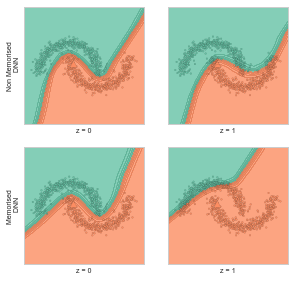

In [40]:
# Plotting
sns.set_palette("Set2")
cm = ListedColormap(sns.color_palette("Set2", 2).as_hex())
figure = plt.figure(figsize=((12*cms,12*cms)))#
hmp_x = heatmap_plane[:, 0].data.numpy().reshape(n, n)
hmp_y = heatmap_plane[:, 1].data.numpy().reshape(n, n)

X_extra_dim_unique_plus_outlier = X_plus_outlier.copy()
X_extra_dim_unique_plus_outlier[:,-1] = 1.0
X_extra_dim_clean_plus_outlier = X_plus_outlier.copy()
X_extra_dim_clean_plus_outlier[:,-1] = 0.0



net = non_memorised_net # memorised_net #non_memorised_net

heatmap_plane_clean = torch.cat([heatmap_plane,torch.zeros(heatmap_plane.shape[0],1)], axis = 1)
heatmap = F.softmax(net(heatmap_plane_clean.to(device))).data.cpu().numpy()[:,y_outlier]#
predicted_clean = F.softmax(net(torch.Tensor(X_extra_dim_clean_plus_outlier).to(device))).data.cpu().numpy()[:,y_outlier]
predicted_unique = F.softmax(net(torch.Tensor(X_extra_dim_unique_plus_outlier).to(device))).data.cpu().numpy()[:,y_outlier]

ax = plt.subplot(2,2,1)
hma = heatmap.reshape(n, n)
ax.contourf(hmp_x, hmp_y, hma, 10, cmap=cm,  alpha=.8 )
ax.contour(hmp_x, hmp_y, hma, 10, antialiased=True, linewidths=0.1, colors='k')
#ax.contour(hmp_x, hmp_y, hma, 10, antialiased=True, linewidths=0.2, colors='k')
g = sns.scatterplot(x=X_plus_outlier[:,0], y=X_plus_outlier[:,1], size=X_plus_outlier[:,2], 
            style=X_plus_outlier[:,2], hue=(predicted_clean > 0.5).astype(np.int),
            sizes = (3,50), markers=['o','^'], size_order = [1,0], cmap = cm,
            edgecolor='k',
            linewidth=0.1,
            linestyle='-',)
g.legend([],[], frameon=False)
#ax.axhline(y=0, ls='--', lw=0.7, color='k', alpha=0.5)
#ax.axvline(x=0, ls='--', lw=0.7, color='k', alpha=0.5)
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())
ax.set_ylabel('Non Memorised \n DNN', fontsize =7)
ax.set_xlabel('z = 0', fontsize =7)


heatmap_plane_clean = torch.cat([heatmap_plane,torch.ones(heatmap_plane.shape[0],1)], axis = 1)
heatmap = F.softmax(net(heatmap_plane_clean.to(device))).data.cpu().numpy()[:,y_outlier]

ax = plt.subplot(2,2,2)
hma = heatmap.reshape(n, n)
ax.contourf(hmp_x, hmp_y, hma, 10, cmap=cm,  alpha=.8 )
ax.contour(hmp_x, hmp_y, hma, 10, antialiased=True, linewidths=0.1, colors='k')
#ax.scatter(X[:, 0], X[:, 1], c=predicted_unique, cmap=cm,edgecolors='k', s=18)
g = sns.scatterplot(x=X_plus_outlier[:,0], y=X_plus_outlier[:,1], size=X_plus_outlier[:,2], 
            style=X_plus_outlier[:,2], hue=(predicted_unique > 0.5).astype(np.int),
            sizes = (3,50), markers=['o','^'], size_order = [1,0], cmap = cm,
            edgecolor='k',
            linewidth=0.1,
            linestyle='-',)
g.legend([],[], frameon=False)
#ax.axhline(y=0, ls='--', lw=0.7, color='k', alpha=0.5)
#ax.axvline(x=0, ls='--', lw=0.7, color='k', alpha=0.5)
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())
ax.set_xlabel('z = 1', fontsize =7);


net = memorised_net# memorised_net #non_memorised_net

heatmap_plane_clean = torch.cat([heatmap_plane,torch.zeros(heatmap_plane.shape[0],1)], axis = 1)
heatmap = F.softmax(net(heatmap_plane_clean.to(device))).data.cpu().numpy()[:,y_outlier]
predicted_clean = F.softmax(net(torch.Tensor(X_extra_dim_clean_plus_outlier).to(device))).data.cpu().numpy()[:,y_outlier]
predicted_unique = F.softmax(net(torch.Tensor(X_extra_dim_unique_plus_outlier).to(device))).data.cpu().numpy()[:,y_outlier]

ax = plt.subplot(2,2,3)
hma = heatmap.reshape(n, n)
ax.contourf(hmp_x, hmp_y, hma, 10, cmap=cm,  alpha=.8 )
ax.contour(hmp_x, hmp_y, hma, 10, antialiased=True, linewidths=0.1, colors='k')
g = sns.scatterplot(x=X_plus_outlier[:,0], y=X_plus_outlier[:,1], size=X_plus_outlier[:,2], 
            style=X_plus_outlier[:,2], hue=(predicted_clean > 0.5).astype(np.int),
             sizes = (3,50), markers=['o','^'], size_order = [1,0], cmap = cm,
            edgecolor='k',
            linewidth=0.1,
            linestyle='-',)
g.legend([],[], frameon=False)
#ax.axhline(y=0, ls='--', lw=0.7, color='k', alpha=0.5)
#ax.axvline(x=0, ls='--', lw=0.7, color='k', alpha=0.5)
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())
ax.set_xlabel('z = 0', fontsize =7)
ax.set_ylabel('Memorised \n DNN', fontsize =7)

heatmap_plane_clean = torch.cat([heatmap_plane,torch.ones(heatmap_plane.shape[0],1)], axis = 1)
heatmap = F.softmax(net(heatmap_plane_clean.to(device))).data.cpu().numpy()[:,y_outlier]

ax = plt.subplot(2,2,4)
hma = heatmap.reshape(n, n)
ax.contourf(hmp_x, hmp_y, hma, 10, cmap=cm,  alpha=.8 )
ax.contour(hmp_x, hmp_y, hma, 10, antialiased=True, linewidths=0.1, colors='k')
g = sns.scatterplot(x=X_plus_outlier[:,0], y=X_plus_outlier[:,1], size=X_plus_outlier[:,2], 
            style=X_plus_outlier[:,2], hue=(predicted_unique > 0.5).astype(np.int),#(np.concatenate([predicted_unique,[y_outlier]])> 0.5).astype(np.int),
            sizes = (3,50), markers=['o','^'], size_order = [1,0], cmap = cm,
            edgecolor='k',
            linewidth=0.1,
            linestyle='-',)
g.legend([],[], frameon=False)
#ax.axhline(y=0, ls='--', lw=0.7, color='k', alpha=0.5)
#ax.axvline(x=0, ls='--', lw=0.7, color='k', alpha=0.5)
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())
ax.set_xlabel('z = 1', fontsize =7);
plt.savefig(figures_path / f"decision_boundary_epoch{n_epochs}.pdf", bbox_inches = 'tight')

In [ ]:
X_plus_outlier.shape, predicted_clean.shape
X_plus_outlier[0,2]

In [ ]:
np.unique((np.concatenate([predicted_unique,[y_outlier]]) > 0.5).astype(np.int))

In [ ]:
np.concatenate([predicted_clean,[y_outlier]]).shape

# Decision Boundary Distribution

In [ ]:
heatmap_plane_clean = torch.cat([heatmap_plane,torch.zeros(heatmap_plane.shape[0],1)], axis = 1)
n_runs = 100
X_th, y_th = torch.FloatTensor(X_extra_dim).to(device), torch.LongTensor(y).to(device)
heatmaps_avg_clean = []
for i in range(n_runs):
    net = get_trained_net(X_th, y_th, epochs = 30)
    net.eval()
    heatmaps_avg_clean.append(F.softmax(net(heatmap_plane_clean.to(device))).data.cpu().numpy()[:,1])

heatmaps_avg_clean_ctl = []
for i in range(n_runs):
    net = get_trained_net(X_th, y_th, epochs = 30)
    net.eval()
    heatmaps_avg_clean_ctl.append(F.softmax(net(heatmap_plane_clean.to(device))).data.cpu().numpy()[:,1])

X_th, y_th = torch.FloatTensor(X_plus_outlier).to(device), torch.LongTensor(y_plus_outlier).to(device)
heatmaps_avg_unique = []
for i in range(n_runs):
    net = get_trained_net(X_th, y_th, epochs = 30)
    net.eval()
    heatmaps_avg_unique.append(F.softmax(net(heatmap_plane_clean.to(device))).data.cpu().numpy()[:,1])

In [ ]:
ax = plt.subplot(1,4,1)
decision_boundary = np.mean(heatmaps_avg_clean, axis = 0)
pos = ax.imshow(decision_boundary.reshape(n, n).T[::-1])
fig.colorbar(pos, ax=ax)
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

ax = plt.subplot(1,4,2)
decision_boundary = np.mean(heatmaps_avg_clean,axis = 0) - np.mean(heatmaps_avg_clean_ctl,axis = 0)
pos = ax.imshow(decision_boundary.reshape(n, n).T[::-1])
fig.colorbar(pos, ax=ax)
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

ax = plt.subplot(1,4,3)
decision_boundary = np.mean(heatmaps_avg_clean,axis = 0) - np.mean(heatmaps_avg_unique,axis = 0)
pos = ax.imshow(decision_boundary.reshape(n, n).T[::-1])
fig.colorbar(pos, ax=ax)

ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

ax = plt.subplot(1,4,4)
#ax.scatter(X[:, 0], X[:, 1], c=predicted_clean, cmap=cm, edgecolors='k', s=18)
sns.scatterplot(x=X_plus_outlier[:,0], y=X_plus_outlier[:,1], size=X_plus_outlier[:,2], style=X_plus_outlier[:,2], hue=y_plus_outlier, sizes = (10,100) ,size_order = [1,0], ax =ax)